In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [73]:
#Euler transformer
beta = 1.1
def E_beta(X):
  N= np.shape(X)[0]
  sum = 0
  for i in range(0,N):
    for j in range(0,N):
      sum= sum + np.exp(beta * np.dot(X[i],X[j]))
  return sum/(2*beta* N**2)

def Z(beta, i,X):
  sum = 0
  for k in range(0,np.shape(X)[0]):
    sum = sum + np.exp(np.dot(X[k], X[i])*beta)
  return sum

def f_i(beta, i, X):
  sum = 0
  for k in range(0,np.shape(X)[0]):
    sum = sum + X[k] * np.exp(np.dot(X[k], X[i])*beta)
  sum = sum/ Z(beta, i, X)
  return sum - np.dot(sum,X[i])*X[i]

def f_transformer(t,X):
   X_dot = np.zeros(np.shape(X))
   for i in range(0,np.shape(X)[0]):
    X_dot[i,:] = f_i(beta, i, X)
   return X_dot

def euler(X0, t_start,t_end, steps,f):
  N = np.shape(X0)[0]
  d = np.shape(X0)[1]
  t = np.linspace(t_start,t_end,steps)
  h = (t_end-t_start)/steps
  x_val = np.zeros((len(t), N, d))
  x_val[0] = X0
  for i in range(1,len(t)):
    x_val[i] = f(t[i-1],x_val[i-1])*h+x_val[i-1]
  return t,x_val

def norm(x):
  return np.sqrt(np.dot(x,x))
t_start = 0
t_end = 1
steps = 1000

#Generate random initial conditoins
def normalize(X):
  #X is (N, D)
  normalized =np.zeros_like(X)
  for i in range(0,np.shape(X)[0]):
    normalized[i] = X[i]/norm(X[i])
  return normalized

rand = np.random.default_rng()
mean = np.array([[-1,1], [1,1], [-1,-1], [1,-1]])
var = np.eye(2)*0.01
N_samples = 500
N_particles = 4
d = 2

samples0_np = np.zeros((N_samples, N_particles, d))
for i in range(0,N_particles):
  sample = rand.multivariate_normal(mean[i],var,size = N_samples)#normalize(rand.multivariate_normal(mean[i],var,size = N_samples))
  samples0_np[:,i,:] = sample

samples0 = torch.from_numpy(samples0_np)

t_start_transformer =0
t_end_transformer =15
samples1_np = np.zeros_like(samples0)
for i in range(0,N_samples):
  t, Xt = euler(samples0[i],t_start_transformer,t_end_transformer,steps, f_transformer)
  samples1_np[i] = Xt[steps-1]

# samples1_np = np.zeros((N_samples, N_particles, d))
# for i in range(0,N_particles):
#   sample = rand.multivariate_normal(np.array([[0,1],[1,0],[-1,0],[0,-1]])[i],var,size = N_samples)#normalize(rand.multivariate_normal(mean[i],var,size = N_samples))
#   samples1_np[:,i,:] = sample

samples1 = torch.from_numpy(samples1_np)

samples0_flat = torch.flatten(samples0, 1)
samples1_flat = torch.flatten(samples1, 1)

## Define the Flow Model
Given empirical observations of $X_0\sim \pi_0$ and $X_1\sim \pi_1$,
the rectified flow induced from $(X_0,X_1)$
is an ordinary differentiable model (ODE)
on time $t\in[0,1]$,
$$
d Z_t = v^X(Z_t, t) d t,
$$
which $v$ is set in a way that ensures that $Z_1$ follows $\pi_1$ when $Z_0 \sim \pi_0$. Let $X_t = t X_1 + (1-t)X_0$ be the linear interpolation of $X_0$ and $X_1$. Then $v$ is given by
$$
v^X(z,t) = \mathbb{E}[X_1 - X_0 ~|~ X_t = z  ] =  \arg\min_{v} \int_0^1 \mathbb{E}[|| X_1-X_0 - v(X_t,t) ||^2] \mathrm{d} t,
$$
where the (conditional) expectation is w.r.t. the joint distribution of $(X_0,X_1)$.

We parameterize $v^X(z,t)$ with a 3-layer neural network.

In [45]:
class MLP(nn.Module):
    def __init__(self, input_dim= 8, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)

    def project(self, x, x_input):
      batchsize = x.shape[0]
      x=x.type(torch.float32)
      x_input = x_input.type(torch.float32)
      batch_projected = torch.zeros_like(x)
      for k in range(0,batchsize):
        x_reshape = torch.reshape(x[k],(N_particles,d))
        x_input_reshape = torch.reshape(x_input[k],(N_particles,d))
        x_projected = torch.zeros_like(x_reshape)
        for i in range(0,N_particles):
          x_projected[i] = x_reshape[i]- (x_reshape[i]@ x_input_reshape[i])*x_input_reshape[i]
        batch_projected[k] = torch.flatten(x_projected)
      return batch_projected

    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        inputs = inputs.type(torch.float32)
        x = self.fc1(inputs)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        # x = self.project(x, x_input)

        return x

Then we define the rectfied flow class.

In [46]:
class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0], 1))
    z_t =  t * z1 + (1.-t) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize,1)) * i / N
      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

## Define the training method and other misc. code
We define the training method here. The loss function is:
$$
\min_{\theta}
\int_0^1 E_{X_0 \sim \pi_0, X_1 \sim \pi_1} \left [ {||( X_1 - X_0) - v_\theta\big (X_t,~ t\big)||}^2
\right ] \text{d}t,
~~~~~\text{with}~~~~
X_t = t X_1 + (1-t) X_0.
$$

In [47]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
  loss_curve = []
  for i in range(inner_iters+1):
    optimizer.zero_grad()
    indices = torch.randperm(len(pairs))[:batchsize]
    batch = pairs[indices]
    z0 = batch[:, 0].detach().clone()
    z1 = batch[:, 1].detach().clone()
    z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

    pred = rectified_flow.model(z_t, t)
    loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
    loss = loss.mean()
    loss.backward()

    optimizer.step()
    loss_curve.append(np.log(loss.item())) ## to store the loss curve

  return rectified_flow, loss_curve


Misc. code for plotting figures.

In [ ]:
@torch.no_grad()
def draw_plot(rectified_flow, z0, z1, N=None):
  traj = rectified_flow.sample_ode(z0=z0, N=N)

  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)

  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[0][:, 0].cpu().numpy(), traj[0][:, 1].cpu().numpy(), label=r'$\pi_0$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()

  traj_particles = torch.stack(traj)
  plt.figure(figsize=(4,4))
  plt.xlim(-M,M)
  plt.ylim(-M,M)
  plt.axis('equal')
  for i in range(30):
    plt.plot(traj_particles[:, i, 0], traj_particles[:, i, 1])
  plt.title('Transport Trajectory')
  plt.tight_layout()

In [74]:
# x_0 = samples0_flat.detach().clone()[torch.randperm(len(samples0_flat))]
# x_1 = samples1_flat.detach().clone()[torch.randperm(len(samples1_flat))]
print(samples0_flat.shape)
x_pairs = torch.stack([samples0_flat, samples1_flat], dim=1)
print(x_pairs.shape)

torch.Size([500, 8])
torch.Size([500, 2, 8])


We create ```rectified_flow_1``` and its corresponding ```optimizer``` and traing 1-Rectified Flow with ```train_rectified_flow``` using $(X_0, X_1)$ above.

Text(0.5, 1.0, 'Training Loss Curve')

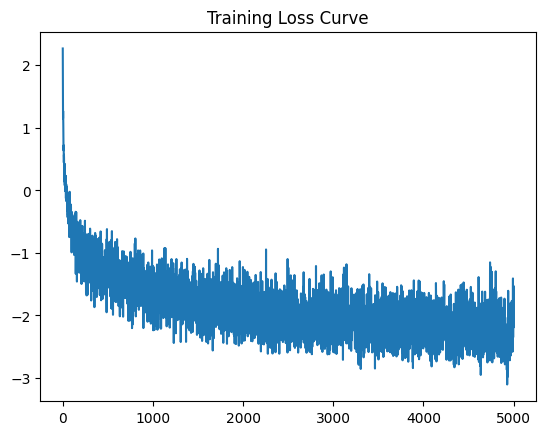

In [75]:
iterations = 5000
batchsize = 48
input_dim = d*N_particles

rectified_flow_1 = RectifiedFlow(model=MLP(input_dim, hidden_num=100), num_steps=100)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')

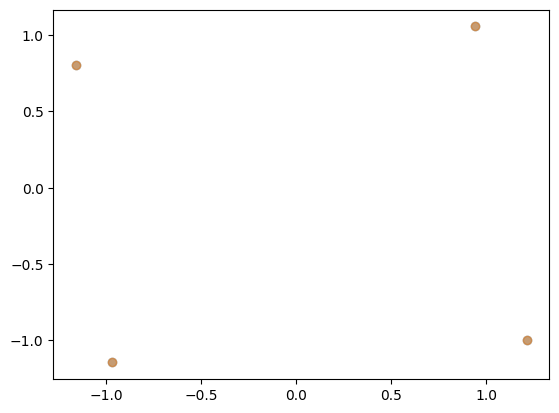

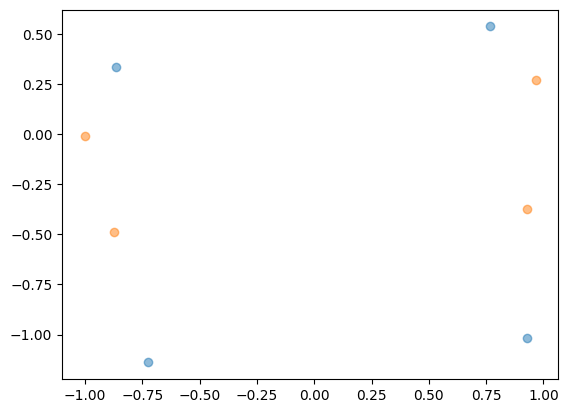

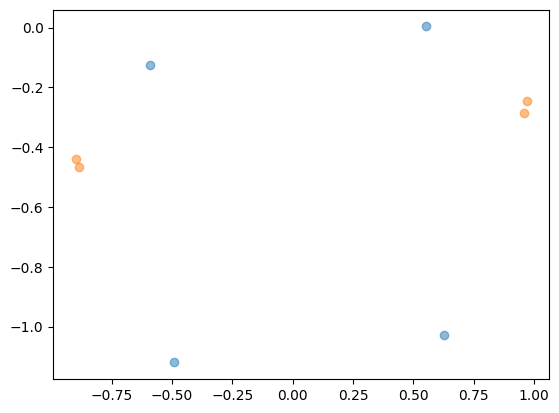

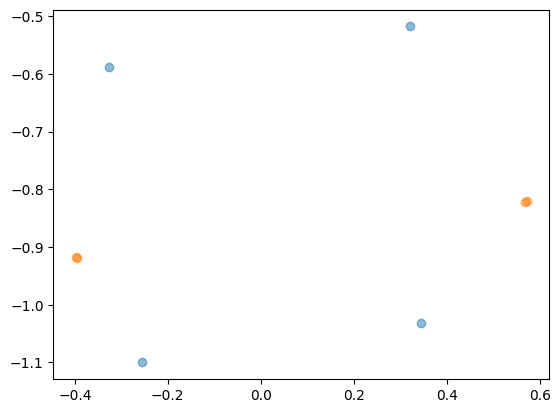

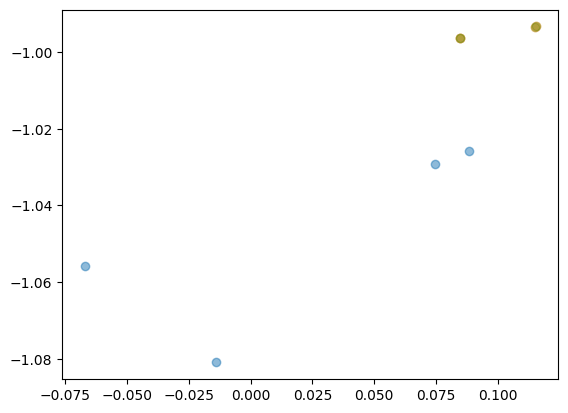

In [76]:
def v_trained(t,x):
  xshape=np.shape(x)
  x=x.flatten()
  x = torch.from_numpy(x).unsqueeze(0)
  t = torch.from_numpy(np.array([t])).unsqueeze(0)
  return rectified_flow_1.model(x,t).detach().numpy().flatten().reshape(xshape)

# X0 = np.array([[-1,1]/norm([-1,1]), [-2,-3]/norm([-2,-3]), [1,1]/norm([1,1]),[6,-3]/norm([6,-3])])
X0=samples0_np[0].reshape(4,2)
t_vtrained,Xt_vtrained=euler(X0,t_start,t_end,steps, v_trained)
t_transformer, X_transformer = euler(X0,t_start_transformer,t_end_transformer,steps, f_transformer)

N_visualize = 500
XT_vtrained = np.zeros((N_visualize, N_particles,d))
for i in range(0,N_visualize):
  t,x=euler(samples0_np[i].reshape(4,2),t_start,t_end,steps, v_trained)
  XT_vtrained[i] = x[steps-1]


plt.figure()
# plt.xlim(-1.1,1.1)
# plt.ylim(-1.1,1.1)
plt.scatter(Xt_vtrained[0,:,0],Xt_vtrained[0,:,1],alpha=0.5)
plt.scatter(X_transformer[0,:,0],X_transformer[0,:,1],alpha=0.5)


plt.figure()
# plt.xlim(-1.1,1.1)
# plt.ylim(-1.1,1.1)
plt.scatter(Xt_vtrained[250,:,0],Xt_vtrained[250,:,1],alpha=0.5)
plt.scatter(X_transformer[250,:,0],X_transformer[250,:,1],alpha=0.5)
plt.show()

plt.figure()
# plt.xlim(-1.1,1.1)
# plt.ylim(-1.1,1.1)
plt.scatter(Xt_vtrained[500,:,0],Xt_vtrained[500,:,1],alpha=0.5)
plt.scatter(X_transformer[500,:,0],X_transformer[500,:,1],alpha=0.5)
plt.show()

plt.figure()
# plt.xlim(-1.1,1.1)
# plt.ylim(-1.1,1.1)
plt.scatter(Xt_vtrained[750,:,0],Xt_vtrained[750,:,1],alpha=0.5)
plt.scatter(X_transformer[750,:,0],X_transformer[750,:,1],alpha=0.5)
plt.show()

plt.figure()
# plt.xlim(-1.1,1.1)
# plt.ylim(-1.1,1.1)
plt.scatter(Xt_vtrained[999,:,0],Xt_vtrained[999,:,1],alpha=0.5)
plt.scatter(X_transformer[999,:,0],X_transformer[999,:,1],alpha=0.5)
plt.scatter(samples1_np[0,:,0],samples1_np[0,:,1],alpha=0.2)
plt.show()

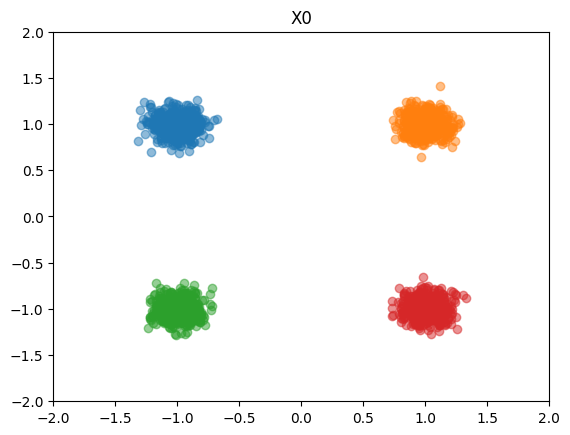

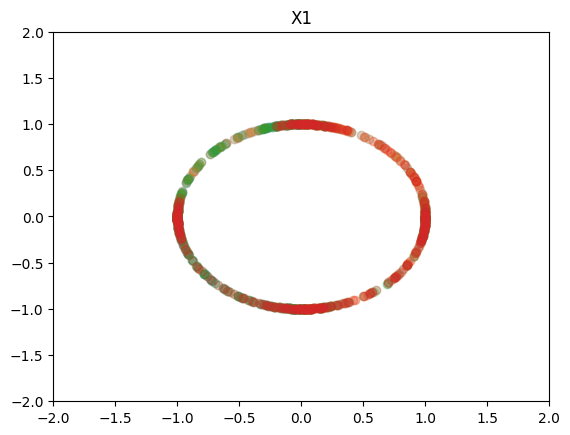

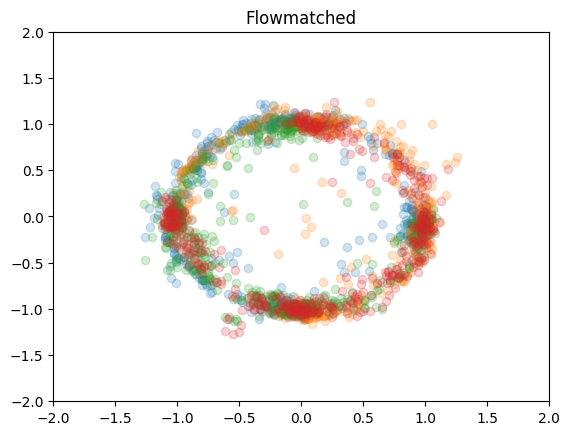

In [83]:
plt.title('X0')
plt.scatter(samples0_np[:,0,0],samples0_np[:,0,1],alpha=0.5)
plt.scatter(samples0_np[:,1,0],samples0_np[:,1,1],alpha=0.5)
plt.scatter(samples0_np[:,2,0],samples0_np[:,2,1],alpha=0.5)
plt.scatter(samples0_np[:,3,0],samples0_np[:,3,1],alpha=0.5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()
plt.figure()
plt.title('X1')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(samples1_np[:,0,0],samples1_np[:,0,1],alpha=0.2)
plt.scatter(samples1_np[:,1,0],samples1_np[:,1,1],alpha=0.2)
plt.scatter(samples1_np[:,2,0],samples1_np[:,2,1],alpha=0.2)
plt.scatter(samples1_np[:,3,0],samples1_np[:,3,1],alpha=0.2)
plt.show()
plt.figure()
plt.title('Flowmatched')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(XT_vtrained[0:N_visualize,0,0],XT_vtrained[:,0,1],alpha=0.2)
plt.scatter(XT_vtrained[0:N_visualize,1,0],XT_vtrained[:,1,1],alpha=0.2)
plt.scatter(XT_vtrained[0:N_visualize,2,0],XT_vtrained[:,2,1],alpha=0.2)
plt.scatter(XT_vtrained[0:N_visualize,3,0],XT_vtrained[:,3,1],alpha=0.2)

Text(0.5, 1.0, 'learned flow trajectory')

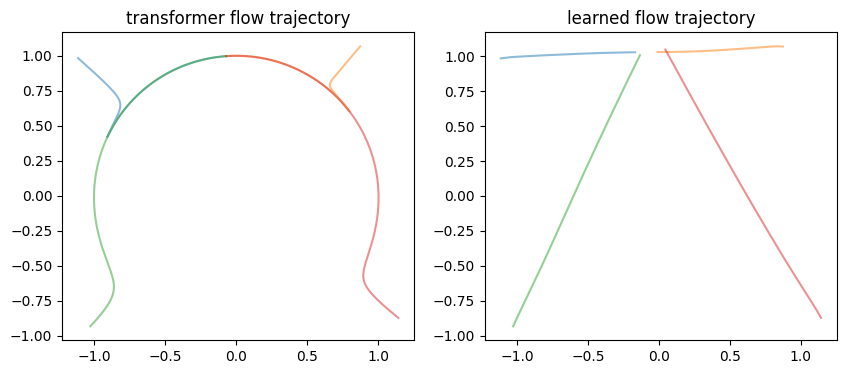

In [96]:
X0=samples0_np[4].reshape(4,2)
t_vtrained,Xt_vtrained=euler(X0,t_start,t_end,steps, v_trained)
t_transformer, X_transformer = euler(X0,t_start_transformer,t_end_transformer,steps, f_transformer)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(X_transformer[:,0,0],X_transformer[:,0,1],alpha=0.5)
ax1.plot(X_transformer[:,1,0],X_transformer[:,1,1],alpha=0.5)
ax1.plot(X_transformer[:,2,0],X_transformer[:,2,1],alpha=0.5)
ax1.plot(X_transformer[:,3,0],X_transformer[:,3,1],alpha=0.5)
ax1.set_title('transformer flow trajectory')

ax2.plot(Xt_vtrained[:,0,0],Xt_vtrained[:,0,1],alpha=0.5)
ax2.plot(Xt_vtrained[:,1,0],Xt_vtrained[:,1,1],alpha=0.5)
ax2.plot(Xt_vtrained[:,2,0],Xt_vtrained[:,2,1],alpha=0.5)
ax2.plot(Xt_vtrained[:,3,0],Xt_vtrained[:,3,1],alpha=0.5)
ax2.set_title('learned flow trajectory')
